# logo2logo
## A pix2pix application
### Using TensorFlow Estimator

## Preperation

In [0]:
import tensorflow as tf

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import PIL
from IPython.display import clear_output
import shutil

In [0]:
# extract training set
# shutil.unpack_archive('train.zip', extract_dir='train', format='zip')
TRAIN_PATH = './train/train/'

BUFFER_SIZE = 500
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUT_CHANNELS = 3
LAMBDA = 100
EPOCHS = 600


def load_image(image_file, is_train):
  input_image = tf.read_file(image_file)
  input_image = tf.image.decode_jpeg(input_image, channels=3)
  input_image = tf.cast(input_image, tf.float32) # RGB [0, 255]
  if is_train: 
    real_image = tf.read_file(tf.strings.regex_replace(image_file, '-input.jpg', '-target.jpg'))
    real_image = tf.image.decode_jpeg(real_image, channels=3)
#   w = tf.shape(image)[1]
#   w = w // 2
#   real_image = image[:, :w, :]
#   input_image = image[:, w:, :]
    real_image = tf.cast(real_image, tf.float32)

    # random jittering
    # resize to 286 * 286 * 3
    input_image = tf.image.resize_images(input_image, [286, 286],
                                       align_corners=True,
                                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize_images(real_image, [286, 286],
                                       align_corners=True,
                                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # random cropping to 256 * 256 * 3
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    input_image, real_image = cropped_image[0], cropped_image[1]
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image
    
#     if np.random.random() > 0.5:
#       input_image = tf.image.flip_left_right(input_image)
#       real_image = tf.image.flip_left_right(real_image)
  else:
    input_image = tf.image.resize_images(input_image, size=[IMG_HEIGHT, IMG_WIDTH], 
                                         align_corners=True, method=tf.image.ResizeMethod.BILINEAR)
#     real_image = tf.image.resize_images(real_image, size=[IMG_HEIGHT, IMG_WIDTH], 
#                                         align_corners=True, method=tf.image.ResizeMethod.BILINEAR)
#     input_max, input_min = tf.reduce_max(input_image), tf.reduce_min(input_image)
#     input_image = (input_image - input_min) * 255.0 / (input_max - input_min)
#     real_max, real_min = tf.reduce_max(real_image), tf.reduce_min(real_image)
#     real_image = (real_image - real_min) * 255.0 / (real_max - real_min)
  # normalize to [-1, 1]
    input_image = (input_image / 127.5) - 1
    return input_image


In [0]:
# data input function
def train_input_fn():
  train_dataset = tf.data.Dataset.list_files(TRAIN_PATH + '*-input.jpg')
  train_dataset = train_dataset.shuffle(BUFFER_SIZE)
  train_dataset = train_dataset.map(lambda x: load_image(x, True)).repeat()
  train_dataset = train_dataset.batch(BATCH_SIZE)
  return train_dataset.make_one_shot_iterator().get_next(name='data_input')



## Generator & Discriminator

In [0]:
# generator

def downsample(x, filters, size, apply_batchnorm=True): # for both gen and disc
  initializer = tf.initializers.random_normal(0, 0.02)
  output = tf.layers.conv2d(x, filters, kernel_size=size,
                           strides=2, padding='same', use_bias=False,
                           kernel_initializer=initializer)
  if apply_batchnorm:
    output = tf.layers.batch_normalization(output, training=True) # always use training
  output = tf.nn.leaky_relu(output)
  return output

def gen_upsample(x, x2, filters, size, apply_dropout=False):
  initializer = tf.initializers.random_normal(0, 0.02)
  output = tf.layers.conv2d_transpose(x, filters, kernel_size=size,
                           strides=2, padding='same', use_bias=False,
                           kernel_initializer=initializer)
  output = tf.layers.batch_normalization(output, training=True)
  if apply_dropout:
    output = tf.layers.dropout(output, rate=0.5, training=True) # always use training
  output = tf.nn.relu(output)
  output = tf.concat([output, x2], axis=-1) # skip connection
  return output

def generator(x): # 256
  with tf.variable_scope('gen'):
  # encode
    x1 = downsample(x, 64, 4, apply_batchnorm=False) # 128
    x2 = downsample(x1, 128, 4) # 64
    x3 = downsample(x2, 256, 4) # 32
    x4 = downsample(x3, 512, 4) # 16
    x5 = downsample(x4, 512, 4) # 8
    x6 = downsample(x5, 512, 4) # 4
    x7 = downsample(x6, 512, 4) # 2
    x8 = downsample(x7, 512, 4) # 1
    # decode
    x9 = gen_upsample(x8, x7, 512, 4, apply_dropout=True) # 2
    x10 = gen_upsample(x9, x6, 512, 4, apply_dropout=True) # 4
    x11 = gen_upsample(x10, x5, 512, 4, apply_dropout=True) # 8
    x12 = gen_upsample(x11, x4, 512, 4) # 16
    x13 = gen_upsample(x12, x3, 256, 4) # 32
    x14 = gen_upsample(x13, x2, 128, 4) # 64
    x15 = gen_upsample(x14, x1, 64, 4) # 128
    x16 = tf.layers.conv2d_transpose(x15, OUT_CHANNELS, kernel_size=4,
                                    strides=2, padding='same',
                                    kernel_initializer=tf.initializers.random_normal(0, 0.02))
    output = tf.nn.tanh(x16, name='gen_output')
  return output

In [0]:
# discriminator

def discriminator(x, y):
  with tf.variable_scope('disc', reuse=tf.AUTO_REUSE):
    initializer = tf.initializers.random_normal(0, 0.02)
    # like encode
    output = tf.concat([x, y], axis=-1) # 256
    output = downsample(output, 64, 4, apply_batchnorm=False) # 128
    output = downsample(output, 128, 4) # 64
    output = downsample(output, 256, 4) # 32
    # we are zero padding here with 1 because we need our shape to 
    # go from (batch_size, 32, 32, 256) to (batch_size, 31, 31, 512)
    paddings = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    output = tf.pad(output, paddings) # 34
    output = tf.layers.conv2d(output, 512, kernel_size=4,
                             strides=1, padding='valid', use_bias=False,
                             kernel_initializer=initializer) # 31
    output = tf.layers.batch_normalization(output, training=True)
    output = tf.nn.leaky_relu(output)
    # padding same way
    output = tf.pad(output, paddings) # 33
    output = tf.layers.conv2d(output, 1, kernel_size=4,
                             strides=1, padding='valid',
                             kernel_initializer=initializer) # 30
    # don't add a sigmoid activation here since
    # the loss function expects raw logits.
    # print(output)
  return output

## Loss

In [0]:
# discriminator loss
def disc_loss(disc_real_output, disc_generated_output):
  real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(disc_real_output),
                                             logits = disc_real_output)
  generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.zeros_like(disc_generated_output),
                                             logits = disc_generated_output)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

# generator loss
def gen_loss(disc_generated_output, gen_output, target):
  gan_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(disc_generated_output),
                                             logits = disc_generated_output)
  l1_loss = tf.reduce_mean(tf.abs(target-gen_output))
  total_gen_loss = gan_loss + LAMBDA * l1_loss
  return total_gen_loss

## Model

In [0]:
TENSOR_TAGS = ['input', 'target', 'prediction']

# hook for showing predictions
class ShowPredictionHook(tf.train.LoggingTensorHook):
  
  def after_run(self, run_context, run_values):
    if self._should_trigger:
      clear_output(wait=True)
      results = run_values.results
      plt.figure(figsize=(15,15))

      titles = ['Input Image', 'Ground Truth', 'Predicted Image']

      for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(titles[i])
        display = results[TENSOR_TAGS[i]][0]
        # print(np.min(display), np.max(display))
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display * 0.5 + 0.5)
        plt.axis('off')
      plt.show()
    super(ShowPredictionHook, self).after_run(run_context, run_values)
    

In [0]:
def p2p_model(features, labels, mode, params):
  # with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
  gen_output = generator(features)
  # print(features, labels, gen_output)
  # predict
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode, predictions={
                                                'output': gen_output,
                                                'input': features})
  disc_real_output = discriminator(features, labels)
  disc_gen_output = discriminator(features, gen_output)
  gen_loss_value = gen_loss(disc_gen_output, gen_output, labels)
  disc_loss_value = disc_loss(disc_real_output, disc_gen_output)
  tf.summary.scalar('gen_loss', gen_loss_value)
  tf.summary.scalar('disc_loss', disc_loss_value)
  # eval
  if mode == tf.estimator.ModeKeys.EVAL:
    return tf.estimator.EstimatorSpec(mode, loss=gen_loss_value + disc_loss_value,
                                      predictions=gen_output)
  step = tf.train.get_global_step()
  # optimizers
  learning_rate = tf.train.exponential_decay(1.5e-4, step,
                                           50000, 0.96, staircase=True)
  gen_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5)
  disc_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5)
  # gen_variables = tf.global_variables(scope='gen/')
  # disc_variables = tf.global_variables(scope='disc/')
  gen_variables = tf.trainable_variables(scope='gen/')
  disc_variables = tf.trainable_variables(scope='disc/')
  
  ## gradient tape is only for eager execution
  # gen_gradients = gen_tape.gradient(gen_loss_value, gen_variables)
  # disc_gradients = disc_tape.gradient(disc_loss_value, disc_variables)
  # gen_train_op = gen_optimizer.apply_gradients(zip(gen_gradients, gen_variables))
  # disc_train_op = disc_optimizer.apply_gradients(zip(disc_gradients, disc_variables))
  
  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  # with tf.control_dependencies(update_ops):
  gen_train_op = gen_optimizer.minimize(gen_loss_value, var_list=gen_variables, 
                                        global_step=step)
  disc_train_op = disc_optimizer.minimize(disc_loss_value, var_list=disc_variables,
                                          global_step=step)
  train_op = tf.group(gen_train_op, disc_train_op)
  # print(len(gen_variables))
  # print(len(disc_variables))
  # train
  return tf.estimator.EstimatorSpec(mode, loss=gen_loss_value + disc_loss_value,
                                    predictions=gen_output, 
                                    train_op=train_op)


## Train

In [12]:
checkpointing_config = tf.estimator.RunConfig(
    save_checkpoints_steps = BUFFER_SIZE,
    keep_checkpoint_max = 5,
)
image_builder = tf.estimator.Estimator(model_fn=p2p_model, 
                                       model_dir='./logo_checkpoints',
                                       config=checkpointing_config)
# this hook is used to show current predictions, i.e. the performance of the current net
predict_hook = ShowPredictionHook(tensors={TENSOR_TAGS[0]: 'data_input:0',
                                          TENSOR_TAGS[1]: 'data_input:1',
                                          TENSOR_TAGS[2]: 'gen/gen_output:0'},
                                 every_n_iter=BUFFER_SIZE,
                                 formatter=lambda tensors: None)
# image_builder.train(input_fn=train_input_fn,
#                     steps=BUFFER_SIZE*EPOCHS/BATCH_SIZE,
#                     hooks=[predict_hook])

INFO:tensorflow:Using config: {'_model_dir': './logo_checkpoints', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9e20ef4dd8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Test

In [0]:
# shutil.unpack_archive('test.zip', extract_dir='./', format='zip')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./logo_checkpoints/model.ckpt-300002
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


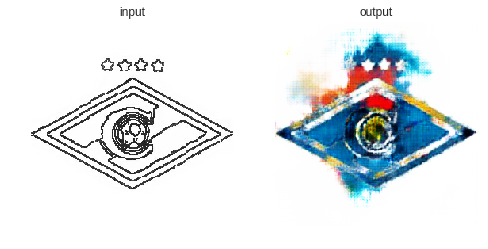

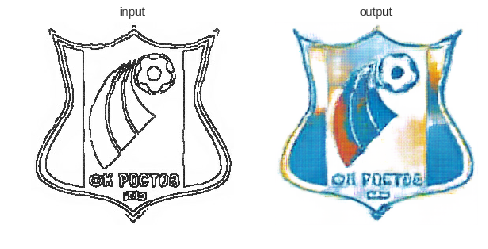

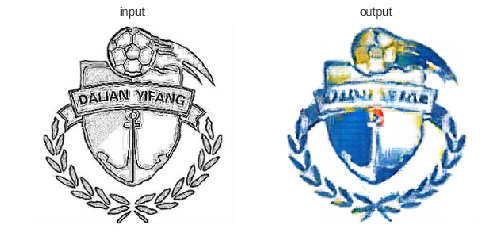

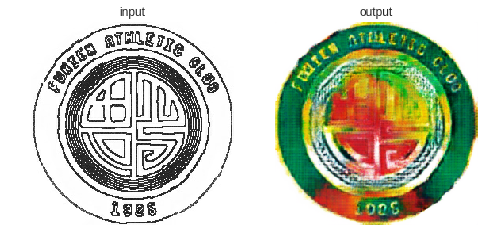

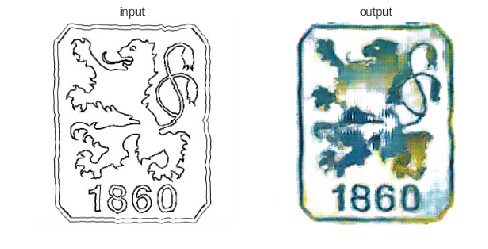

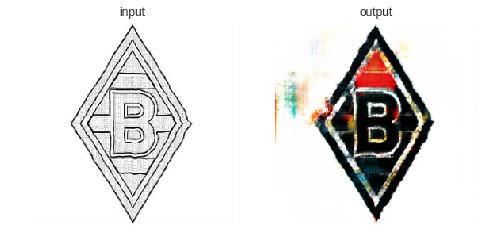

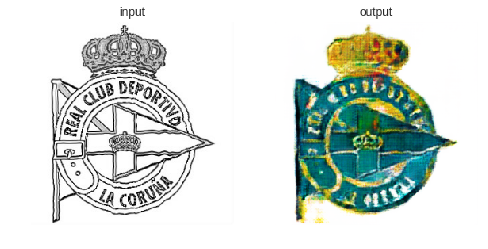

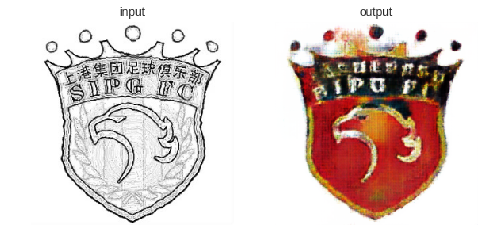

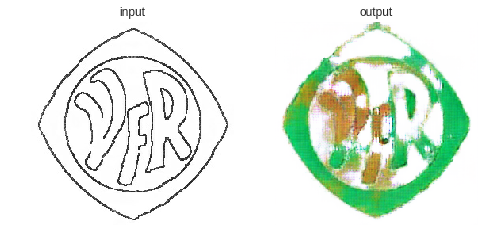

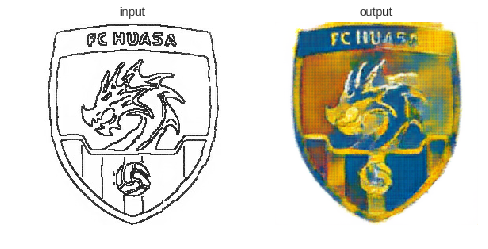

All results saved to ./logo-results


In [16]:
# test set
TEST_PATH = './test/'
def test_input_fn():
  test_dataset = tf.data.Dataset.list_files(TEST_PATH + '*.jpg')
  test_dataset = test_dataset.map(lambda x: load_image(x, False))
  test_dataset = test_dataset.batch(BATCH_SIZE)
  return test_dataset.make_one_shot_iterator().get_next(name='data_input')

# show image

from PIL import Image
SAVE_PATH = './logo-results'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

def showImages(feature, prediction):
    titles = ['input', 'output']
    images = [feature, prediction]
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(titles[i])
        display = images[i]
        # getting the pixel values between [0, 1] to plot it.
#         plt.imshow(display * 0.5 + 0.5)
        plt.imshow(display)
        plt.axis('off')
    plt.show()
    
# predictions = image_builder.evaluate(input_fn=test_input_fn)
predictions = image_builder.predict(input_fn=test_input_fn)
for i, prediction in enumerate(predictions):
  # get input and output raw image
  prediction, feature = prediction['output'], prediction['input']
#   print(np.max(prediction), np.max(feature))
  # convert to PIL image
  prediction = np.uint8((prediction + 1) * 127.5)
  feature = np.uint8((feature + 1) * 127.5)
  if i % 20 == 0:
    showImages(feature, prediction)
  pred_img = Image.fromarray(prediction, 'RGB')
  feat_img = Image.fromarray(feature, 'RGB')
  # merge horizontaly into one image 
  merged = Image.new(pred_img.mode, (pred_img.size[0] * 2, pred_img.size[1]))
  merged.paste(feat_img, (0, 0))
  merged.paste(pred_img, (pred_img.size[0], 0))
  # write to file system
  if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
  merged.save('%s/result-%d.jpg' % (SAVE_PATH, i))
print('All results saved to ' + SAVE_PATH)


In [17]:
shutil.make_archive('./logo-results', format='zip', base_dir=SAVE_PATH)

'./logo-results.zip'

## Save Model to Google Drive

In [10]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'model.ckpt-300002.data-00000-of-00001'})
uploaded.SetContentFile('./logos_checkpoints/model.ckpt-300002.data-00000-of-00001')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 14iWhUfiRj2mCyz-pcTSj0Y3tdQVGROdl


## Get Model from Google Drive

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
os.makedirs('./logo_checkpoints/')
file_id = '14iWhUfiRj2mCyz-pcTSj0Y3tdQVGROdl'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('./logo_checkpoints/model.ckpt-300002.data-00000-of-00001')
# print('Downloaded content "{}"'.format(downloaded.GetContentString()))